In [3]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, make_scorer, recall_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


In [4]:
dados = genfromtxt('dados_tratados.csv', delimiter=',')
dados.shape

(167, 13)

In [5]:
X = dados[:, :-1]
y = dados[:, -1]

X_treino_full, X_teste_final, y_treino_full, y_teste_final = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
grid_svm = {
    "svm__C": [2**i for i in range(-5, 16, 2)],
    "svm__gamma": [2**i for i in range(-15, 4, 2)],
    "svm__kernel": ["rbf"]  # opcional aqui, pois já está fixo
}

In [7]:
param_grid_svm = {
    "svm__C": [2**i for i in range(-5, 16, 2)],
    "svm__gamma": [2**i for i in range(-15, 4, 2)],
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline_grid_svm = Pipeline([
    ('sampler', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, kernel="rbf", probability=True))
])

grid_search_dt = GridSearchCV(
    estimator=pipeline_grid_svm,
    param_grid=param_grid_svm,
    cv=cv_strategy,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
)

print("Starting Grid Search for best SVM parameters...")
grid_search_dt.fit(X_treino_full, y_treino_full)

print("\n--- Grid Search Results ---")
print(f"Best parameters found: {grid_search_dt.best_params_}")
print(f"Best cross-validation F1-score: {grid_search_dt.best_score_:.4f}")

Starting Grid Search for best SVM parameters...

--- Grid Search Results ---
Best parameters found: {'svm__C': 2, 'svm__gamma': 8}
Best cross-validation F1-score: 0.8777



F1-score on the final test set: 0.8163


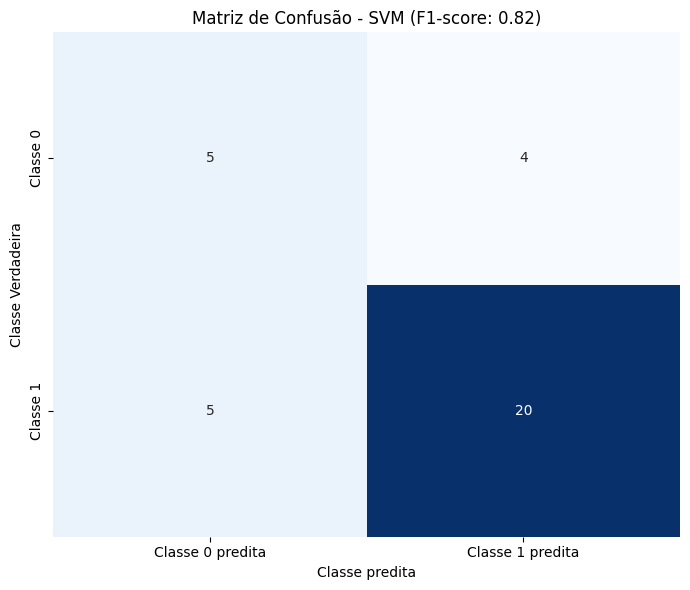

In [11]:
final_pipeline_dt = grid_search_dt.best_estimator_

y_pred_final_dt = final_pipeline_dt.predict(X_teste_final)

f1_final_test_dt = f1_score(y_teste_final, y_pred_final_dt)
print(f"\nF1-score on the final test set: {f1_final_test_dt:.4f}")

cm_dt = confusion_matrix(y_teste_final, y_pred_final_dt)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0 predita', 'Classe 1 predita'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Classe predita')
plt.ylabel('Classe Verdadeira')
plt.title(f'Matriz de Confusão - SVM (F1-score: {f1_final_test_dt:.2f})')
plt.tight_layout()
plt.show()

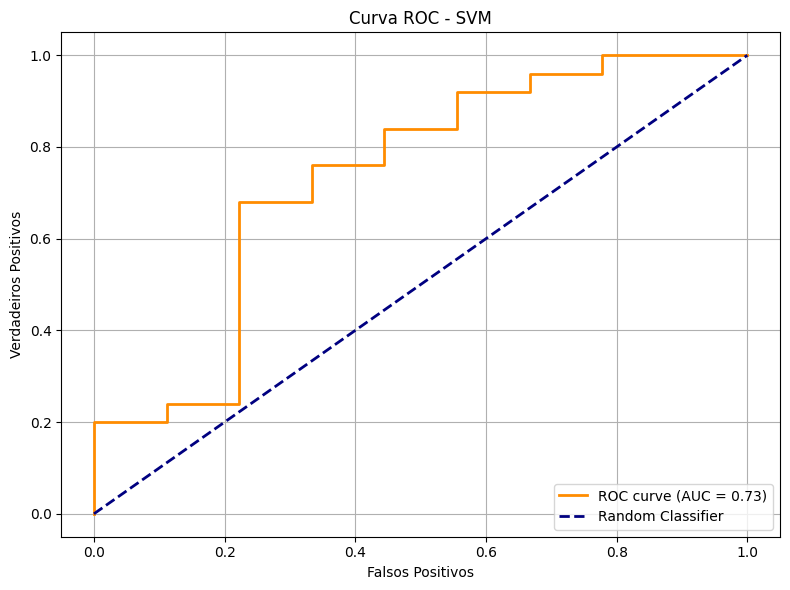

In [12]:
probas_final_dt = final_pipeline_dt.predict_proba(X_teste_final)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_teste_final, probas_final_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('Curva ROC - SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score
)

acc = accuracy_score(y_teste_final, y_pred_final_dt)
recal = recall_score(y_teste_final, y_pred_final_dt)
precis = precision_score(y_teste_final, y_pred_final_dt)
f1 = f1_score(y_teste_final, y_pred_final_dt)

print("Estatísticas svm:")

print(f"Acurácia: {acc:.4f}")
print(f"Revocação: {recal:.4f}")
print(f"Precisão: {precis:.4f}")
print(f"F1-score: {f1:.4f}")


Estatísticas svm:
Acurácia: 0.7353
Revocação: 0.8000
Precisão: 0.8333
F1-score: 0.8163
